In [68]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from skimage.segmentation import active_contour
from skimage import exposure
from scipy.ndimage import gaussian_filter, label
import tifffile as tiff
import os
#import scipy
#from sklearn.mixture import GaussianMixture as GMM

***import pre-processed clustered TIF image***

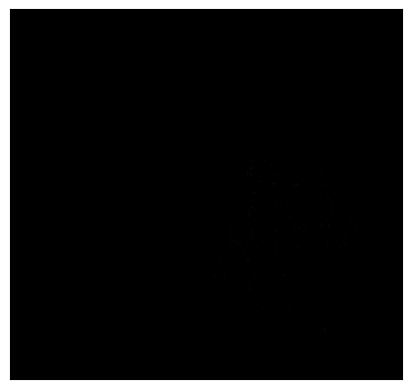

In [69]:
merfish_tif_fname = '/Users/brianbrogan/Desktop/KI24/Cluster:ImgGen2024/MERFISH/output/02. Images/02.1. Raw prediction/H18.06.006.MTG.4000.expand.rep3/clusters/cluster0_from_CTR081_Fron_mean_r10_cap1000.tif'
sterseq_tif_fname = '/Users/brianbrogan/Desktop/KI24/ClusterImgGen2024/STERSEQ/output/02. Images/02.1. Raw prediction/1996-081_GFM_SS200000954BR_A2_tissue_cleaned_cortex_crop/clusters/cluster0_from_1996-081_GFM_SS200000954BR_A2_bin100_tissue_cleaned_mean_r10_cap1000.tif'

test_img = tiff.imread(sterseq_tif_fname)
plt.xticks([])
plt.yticks([])
plt.imshow(test_img)

In [6]:
print(np.min(test_img))
print(np.max(test_img))
print(test_img.shape)


0
255
(11301, 12001, 3)


***threshold and slice***

0
255
(11301, 12001)
(2500, 2250)


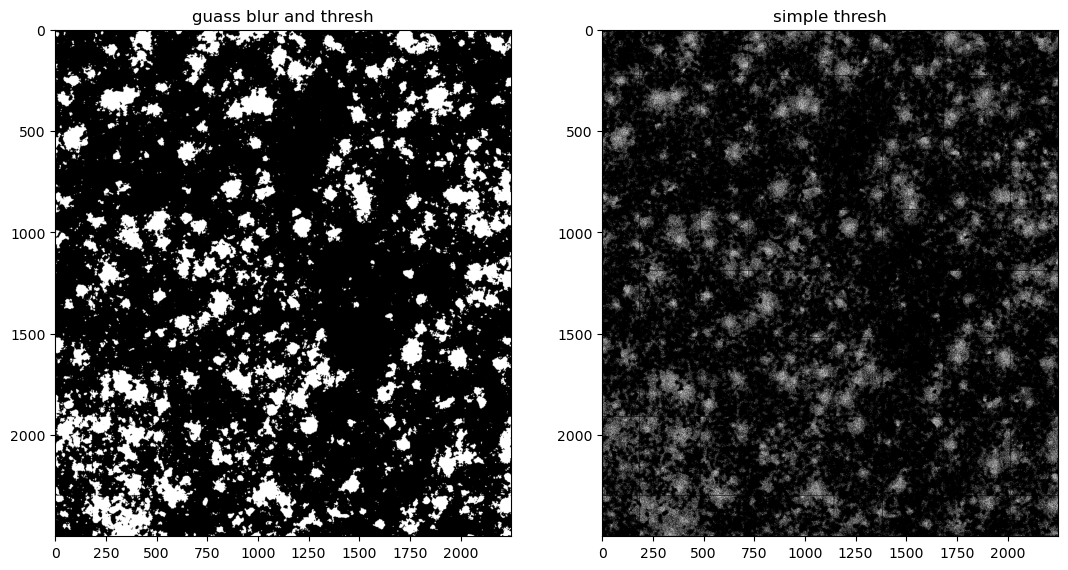

In [71]:
#------------------------------
simple_thresh= False

x_win = (7750, 10000) # first dimension (cols)
y_win = (5000, 7500) # second dimension (rows)

threshline = 0


gauss_k_size = (11, 11)

channel = 'G'

min_area = 100
#------------------------------
chans=['R', 'G', 'B']

test_img_chan = test_img[:,:,chans.index(channel)]
print(np.min(test_img_chan))
print(np.max(test_img_chan))
print(test_img_chan.shape)

#color_slice = cv2.convertScaleAbs(cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR), alpha=1.0, beta=10)[x_win[0]:x_win[1], y_win[0]:y_win[1]]
#color_slice = exposure.rescale_intensity(test_img, in_range=(1, 255), out_range=(0, 255))[x_win[0]:x_win[1], y_win[0]:y_win[1]]

comp_slice = cv2.threshold(test_img_chan, threshline, 255, cv2.THRESH_BINARY)[1][y_win[0]:y_win[1], x_win[0]:x_win[1]]

ret1, bin_img1 = cv2.threshold(test_img_chan, threshline, 255, cv2.THRESH_BINARY)

blur = cv2.GaussianBlur(test_img_chan,gauss_k_size,0)
ret2 ,bin_img2 = cv2.threshold(blur,threshline,255,cv2.THRESH_BINARY)#+cv2.THRESH_OTSU)

if simple_thresh:
    ret, bin_img = ret1, bin_img1
    ret_alt, bin_img_alt = ret2, bin_img2
    title1 = "simple thresh"
    title2 = "guass blur and thresh"
else:
    ret, bin_img = ret2, bin_img2
    ret_alt, bin_img_alt = ret1, bin_img1
    title1 = "guass blur and thresh"
    title2 = "simple thresh"

test_img_chan_slice = test_img_chan[y_win[0]:y_win[1], x_win[0]:x_win[1]]
bin_img_slice = bin_img[y_win[0]:y_win[1], x_win[0]:x_win[1]]
bin_img_alt_slice = bin_img_alt[y_win[0]:y_win[1], x_win[0]:x_win[1]]

print(bin_img_slice.shape)

plt.figure(figsize=(20, 10))

plt.subplot(132)
plt.imshow(bin_img_slice, cmap='gray')
plt.title(title1)
#plt.xticks(np.arange(0, bin_img_slice.shape[1], 100), np.arange(x_win[0], x_win[1], 100))  
#plt.yticks(np.arange(0, bin_img_slice.shape[0], 100), np.arange(y_win[0], y_win[1], 100))  

plt.subplot(133)
plt.imshow(bin_img_alt_slice, cmap='gray')
plt.title(title2)
#plt.xticks(np.arange(0, bin_img_alt_slice.shape[1], 100), np.arange(x_win[0], x_win[1], 100))  
#plt.yticks(np.arange(0, bin_img_alt_slice.shape[0], 100), np.arange(y_win[0], y_win[1], 100))  

plt.show()



In [21]:
def save_tiff_slice(image_fname, xrange, yrange,out_dir="mask_maker_output", tiff_fname='test_slice.tiff'):
        full_img = tiff.imread(image_fname)
        slice = full_img[xrange[0]:xrange[1], yrange[0]:yrange[1]]
        os.makedirs(out_dir, exist_ok=True)
        out_path = os.path.join(out_dir, tiff_fname)
        tiff.imwrite(out_path, slice)
        print(f"TIFF slice saved to {out_path}")

save_tiff_slice(sterseq_tif_fname, x_win, y_win,
                out_dir = '/Users/brianbrogan/Desktop/KI24/mask_maker_output')

TIFF slice saved to /Users/brianbrogan/Desktop/KI24/mask_maker_output/test_slice.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..121.0].


(1000, 1000, 3)


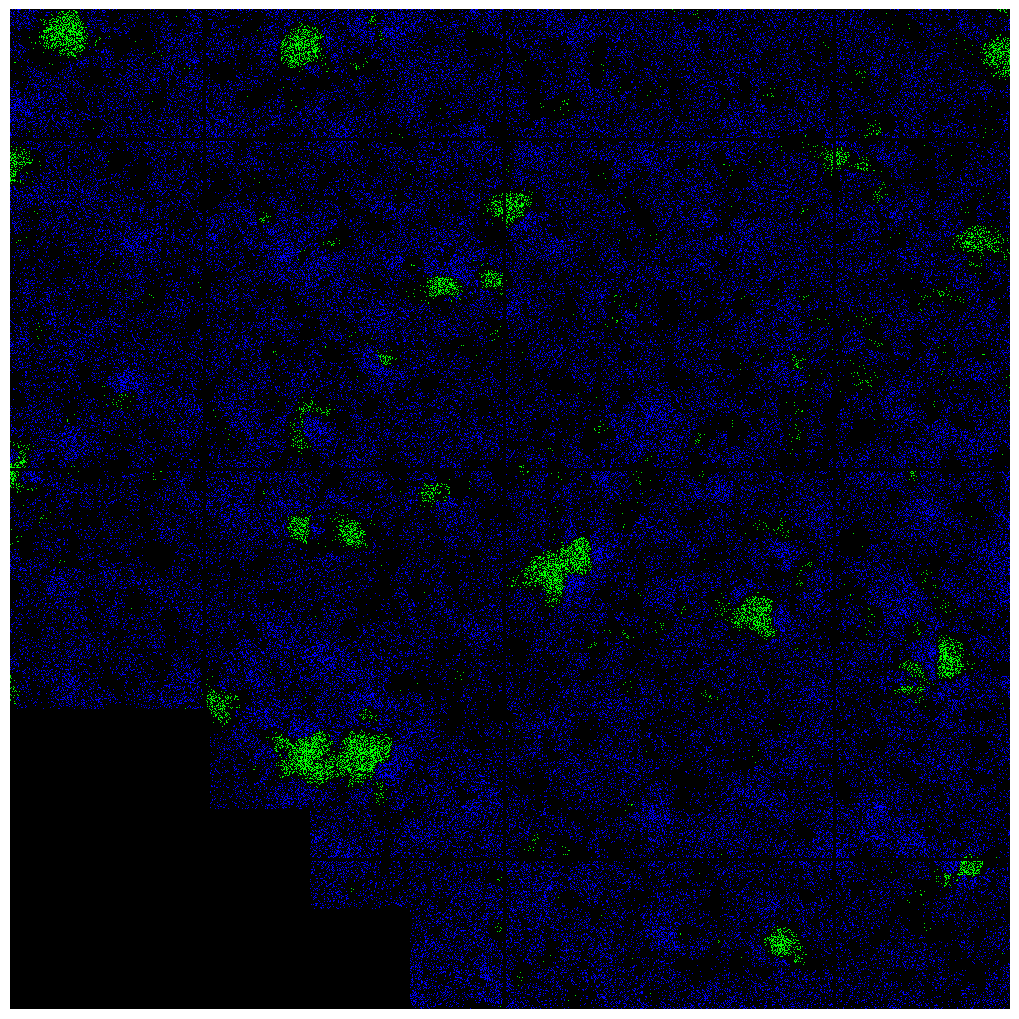

In [8]:
#plt.imshow(cv2.cvtColor(color_slice, cv2.COLOR_BGR2RGB))

color_slice = exposure.rescale_intensity(test_img, in_range=(0, 255), out_range=(0, 255))[x_win[0]:x_win[1], y_win[0]:y_win[1]]
dpi = 100
height, width = color_slice.shape[:2]
print(color_slice.shape)
fig2, ax2 = plt.subplots(figsize=(width/dpi, height/dpi))
ax2.imshow(color_slice, cmap='gray')
ax2.axis('off')
fig2.subplots_adjust(left=0, right=1, top=1, bottom=0)
fig2.savefig('/Users/brianbrogan/Desktop/KI24/figures/color_slice1.tiff',
             dpi=100,
             format='tiff',
             bbox_inches=None,
             pad_inches=0)


***manual opening***

Text(0.5, 1.0, 'thresholded image')

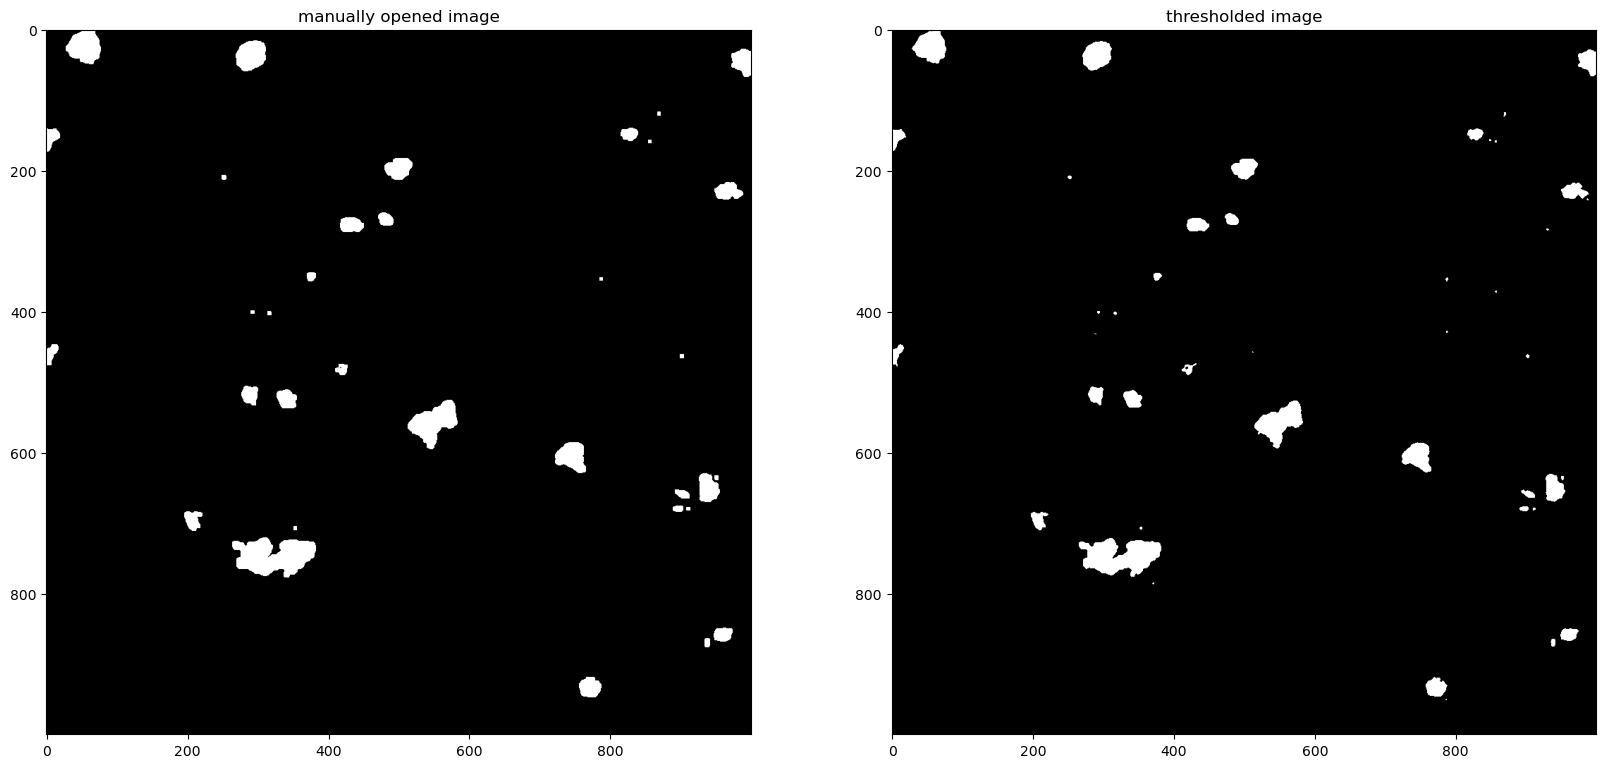

In [9]:
erode_kernel = np.ones((3,3))
dilate_kernel = np.ones((5,5))

img_erode = cv2.erode(bin_img_slice, erode_kernel, iterations=1)
man_opened_img = cv2.dilate(img_erode, dilate_kernel, iterations=1)

fig, ax = plt.subplots(1,2, figsize= (20,10))
ax[0].imshow(man_opened_img, cmap='gray')
ax[0].set_title("manually opened image")
ax[1].imshow(bin_img_slice, cmap='gray')
ax[1].set_title("thresholded image")
#plt.figure(figsize=(10, 10))
#plt.imshow(img_dilation, cmap='gray')

***openCV opened***

Text(0.5, 1.0, 'thresholded image')

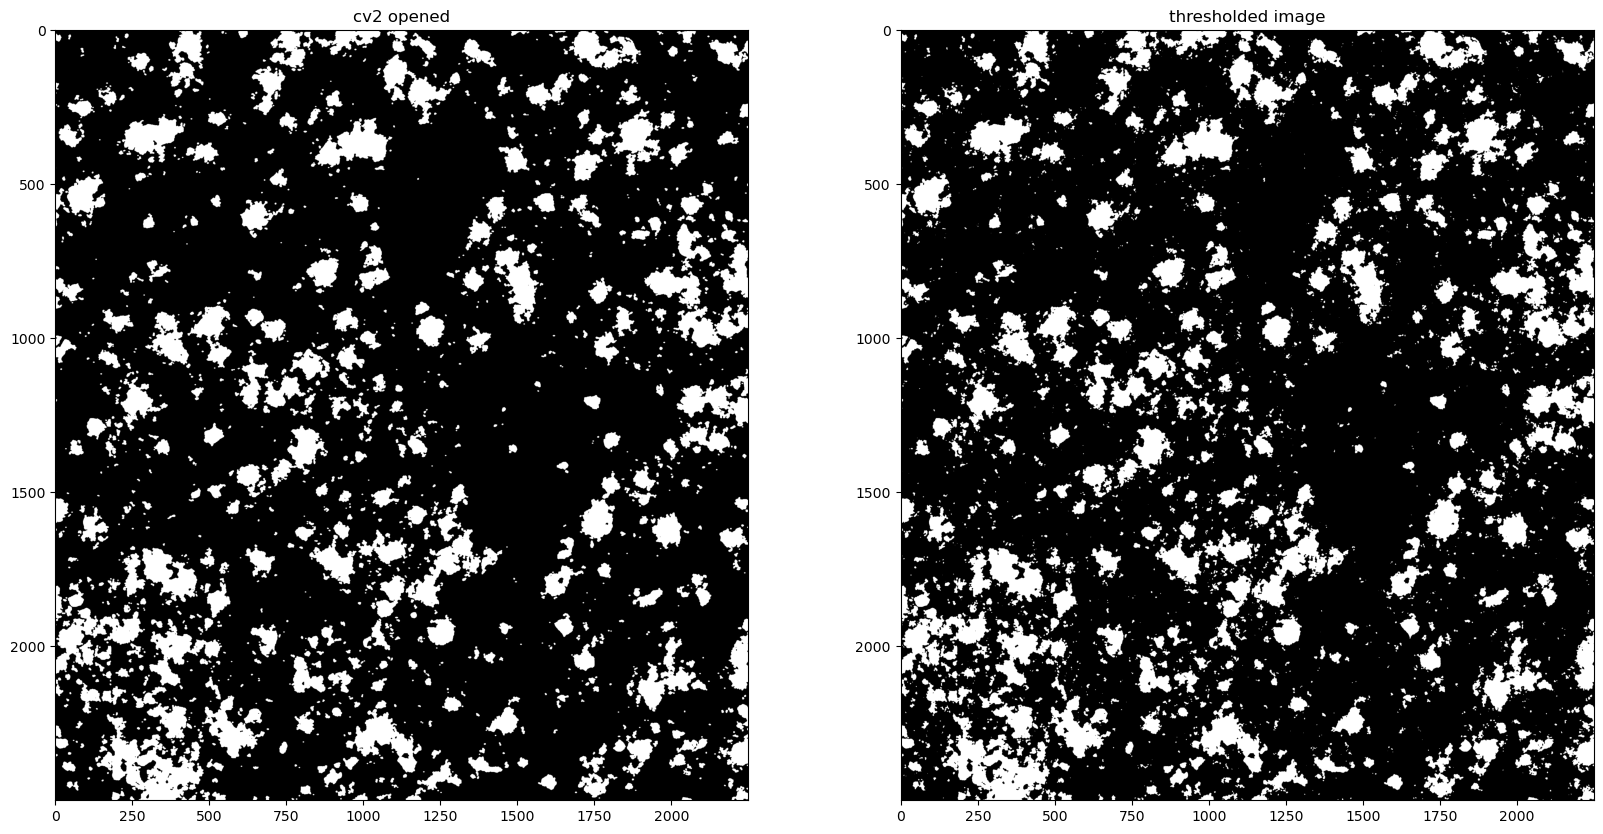

In [72]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
morph_opened_img = cv2.morphologyEx(bin_img_slice, 
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=1)

fig, ax = plt.subplots(1,2, figsize= (20,10))
ax[0].imshow(morph_opened_img, cmap='gray')
ax[0].set_title("cv2 opened")
ax[1].imshow(bin_img_slice, cmap='gray')
ax[1].set_title("thresholded image")

In [73]:
if simple_thresh:
    opened_img = man_opened_img
else:
    opened_img = morph_opened_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..121.0].


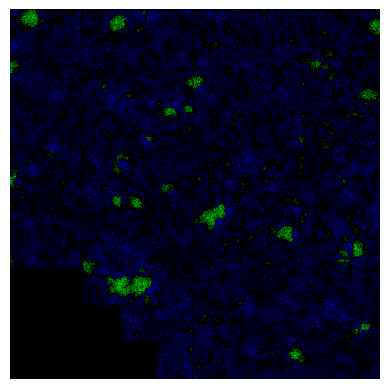

In [8]:
fig2, ax2 = plt.subplots()
ax2.imshow(color_slice, cmap='gray')
ax2.axis('off')
fig2.savefig('/Users/brianbrogan/Desktop/KI24/figures/color_slice.tiff',
             dpi=100,
             format='tiff',
             bbox_inches='tight',
             pad_inches=0)

***cv2 blob detector***
- similar to current method ?

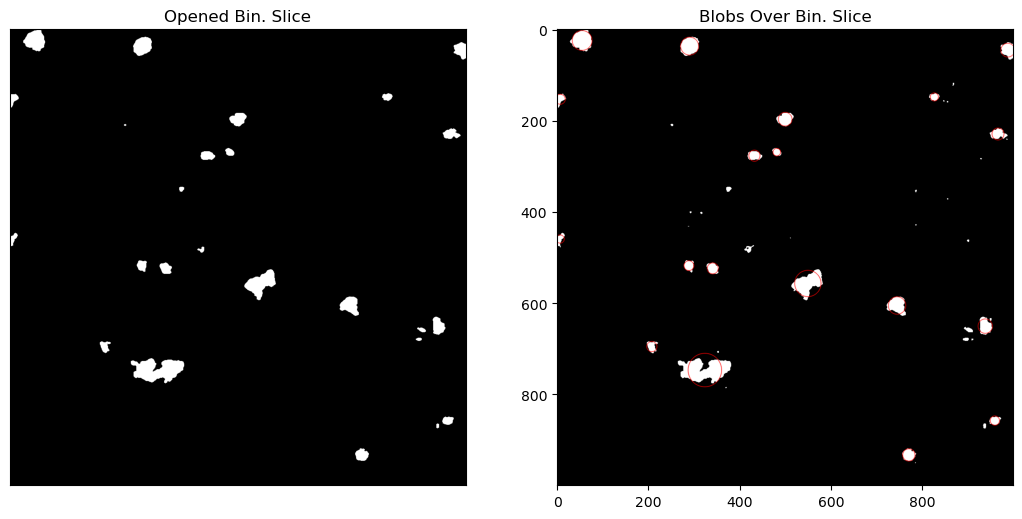

In [12]:
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 200
params.maxArea = 100000

params.filterByColor = True
params.blobColor = 255
#params.filterByCircularity = True
#params.minCircularity = 0.001
params.filterByInertia = False
params.filterByConvexity = False
detector = cv2.SimpleBlobDetector_create(params)
pre_keypoints = detector.detect(opened_img)

img_with_keypoints = cv2.drawKeypoints(opened_img, pre_keypoints, np.ndarray([]), (255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
orig_with_keypoints = cv2.drawKeypoints(bin_img_slice, pre_keypoints, np.ndarray([]), (255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20, 10))
plt.subplot(131),plt.imshow(opened_img, cmap = 'gray')
plt.title('Opened Bin. Slice'), plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.title('Blobs Over Bin. Slice')
plt.imshow(orig_with_keypoints, cmap="gray")

***cv2 contour finder (edge gradient algorithm)***

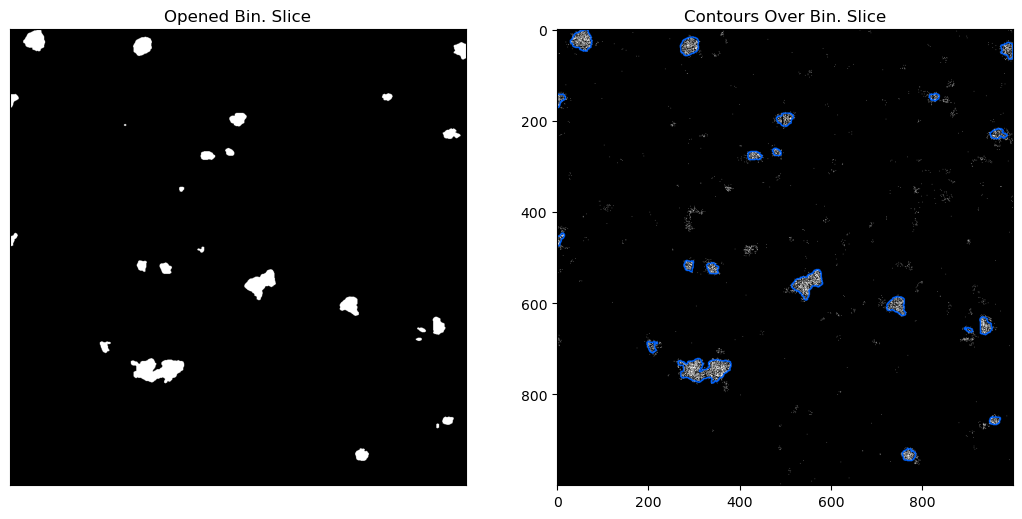

In [13]:
contours, hierarchy = cv2.findContours(opened_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Draw the contours on the original image
output_image = cv2.cvtColor(comp_slice, cv2.COLOR_GRAY2RGB)  # Convert to RGB for colored drawing

filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

cv2.drawContours(output_image, filtered_contours, -1, (0, 100, 255), 2)  # Draw red contours

plt.figure(figsize=(20, 10))
plt.subplot(131),plt.imshow(opened_img, cmap = 'gray')
plt.title('Opened Bin. Slice'), plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.title('Contours Over Bin. Slice')
plt.imshow(output_image, cmap="gray")

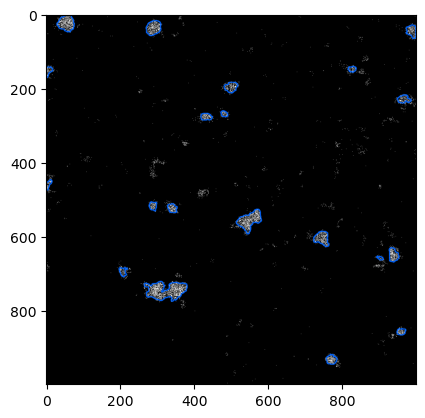

In [12]:
plt.imshow(output_image)


***scipy radial basis function interpolation for probability distribution***
- way too slow, not worth

***cv2 watershed segmentation***

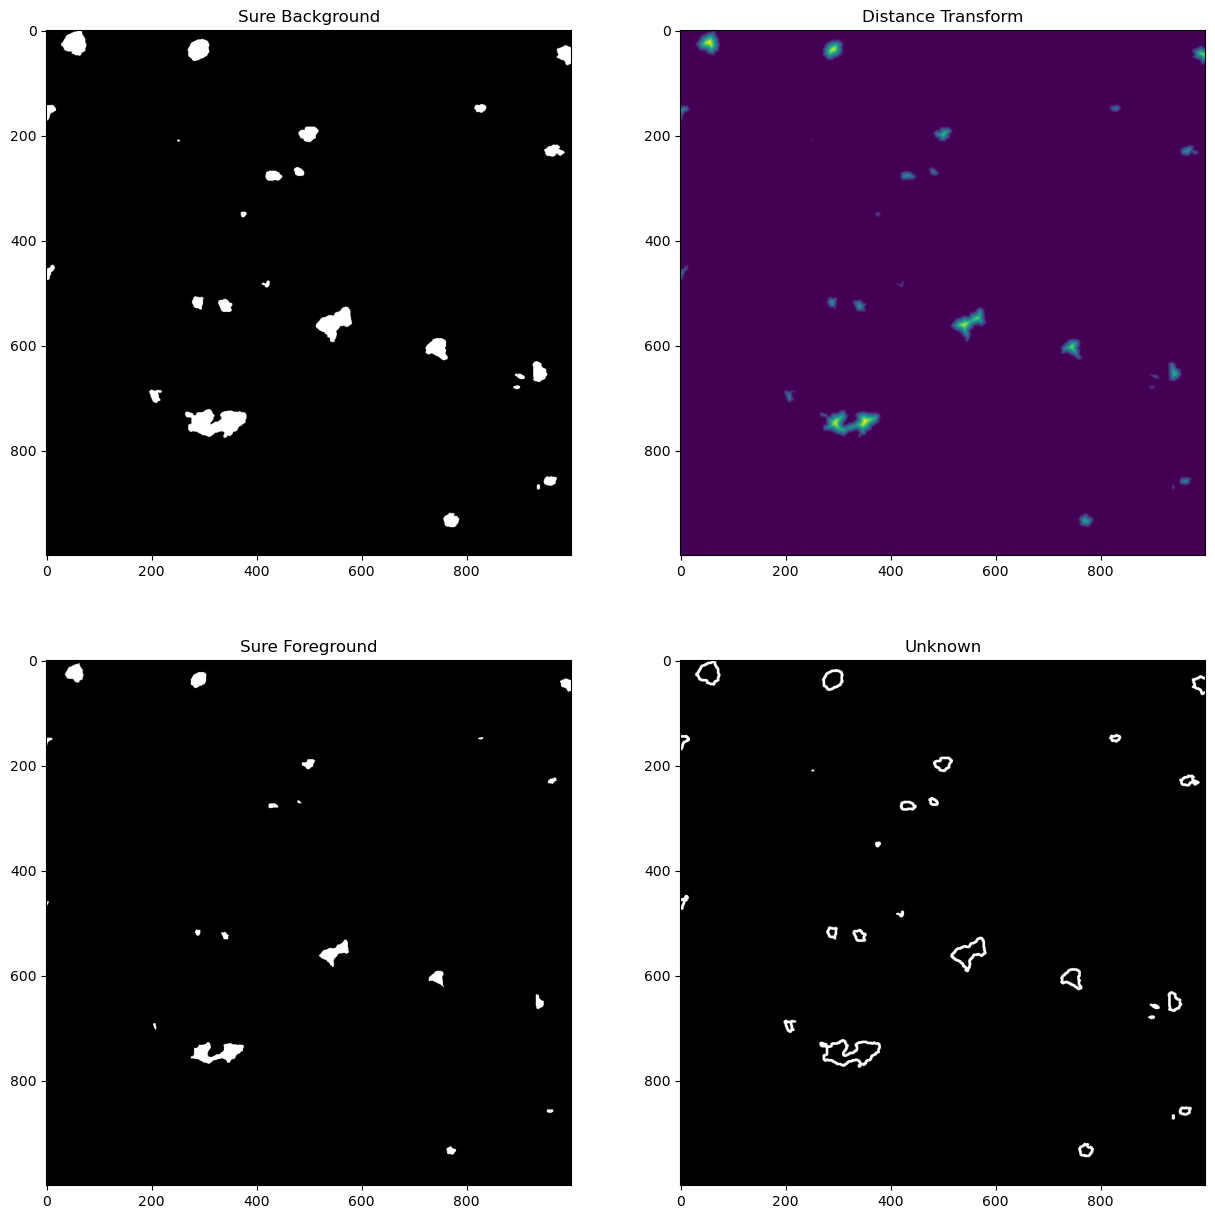

In [14]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
# sure background area.
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1,1))
sure_bg = cv2.dilate(opened_img, kernel, iterations=1)
axes[0,0].imshow(sure_bg, cmap='gray')
axes[0, 0].set_title('Sure Background')
 
# Distance transform
dist = cv2.distanceTransform(opened_img, cv2.DIST_L2, 5)
axes[0,1].imshow(dist, cmap='viridis')
axes[0, 1].set_title('Distance Transform')
 
#foreground area
ret, sure_fg = cv2.threshold(dist, 0.3 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)  
axes[1,0].imshow(sure_fg, cmap='gray')
axes[1, 0].set_title('Sure Foreground')
 
# unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
axes[1,1].imshow(unknown, cmap='gray')
axes[1, 1].set_title('Unknown')
 
plt.show()

(1000, 1000)
(1000, 1000)


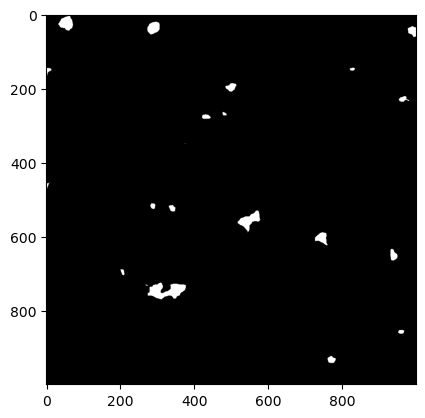

In [14]:
print(dist.shape)

smoothed_dt = gaussian_filter(dist, sigma=1)

# Step 3: Threshold to find local maxima
# You can adjust the threshold based on your application
threshold = np.percentile(smoothed_dt, 99)  # 90th percentile as a threshold
local_maxima = (smoothed_dt > threshold).astype(np.uint8)
#num_labels, markers = cv2.connectedComponents(local_maxima)

print(local_maxima.shape)
plt.imshow(local_maxima, cmap='gray')

# Step 5: Increment labels so that the background is not 0
#markers += 1

In [16]:
# Marker labelling
# sure foreground 
ret, markers = cv2.connectedComponents(dist)
 
# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0
 
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()
print(markers.shape)

error: OpenCV(4.10.0) /Users/runner/miniforge3/conda-bld/libopencv_1727648921144/work/modules/imgproc/src/connectedcomponents.cpp:5632: error: (-215:Assertion failed) iDepth == CV_8U || iDepth == CV_8S in function 'connectedComponents_sub1'


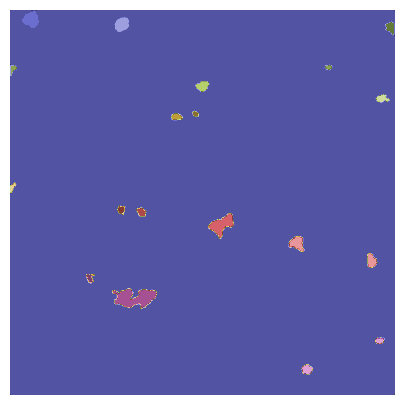

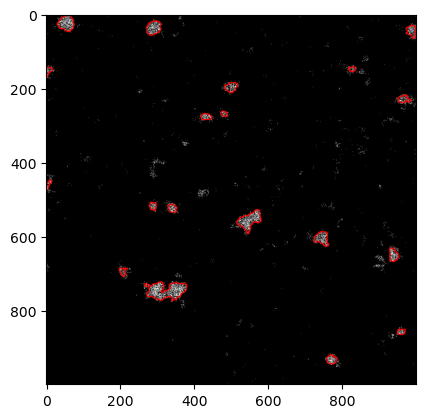

In [16]:
# watershed Algorithm
markers = cv2.watershed(cv2.cvtColor(opened_img, cv2.COLOR_GRAY2BGR), np.int32(markers))
 
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()
 
 
labels = np.unique(markers)
 
coins = []
for label in labels[2:]:  

 
# Create a binary image in which only the area of the label is in the foreground 
#and the rest of the image is in the background   
    target = np.where(markers == label, 255, 0).astype(np.uint8)
   
  # Perform contour extraction on the created binary image
    contours, hierarchy = cv2.findContours(
        target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )
    coins.append(contours[0])
filtered_coins = [cnt for cnt in coins if cv2.contourArea(cnt) > min_area]
# Draw the outline
watershed_img = cv2.drawContours(cv2.cvtColor(comp_slice, cv2.COLOR_GRAY2RGB), filtered_coins, -1, color=(255, 0, 0), thickness=2)
plt.imshow(watershed_img)

***Active Contour Model (ACM)***

-too slow, also wack

-requires intensive preprocessing for each cell, lose the fine details of the contour, needs initialization bounding box

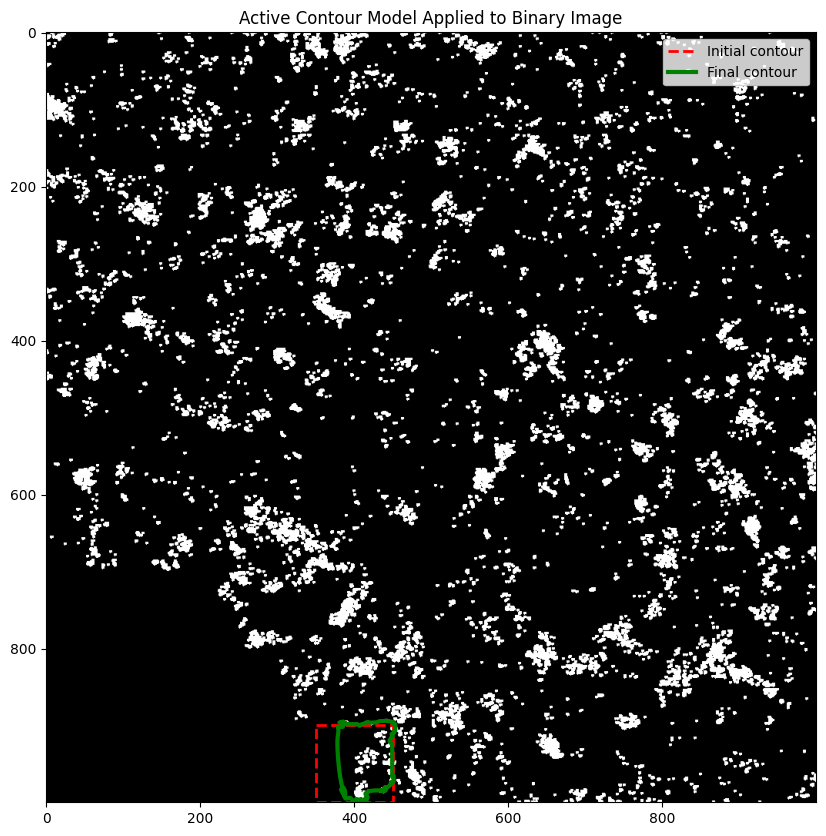

In [249]:
rows, cols = opened_img.shape

square_size = 100  
start_row, start_col = 899, 350 

top_left = (start_row, start_col)
top_right = (start_row, start_col + square_size)
bottom_right = (start_row + square_size, start_col + square_size)
bottom_left = (start_row + square_size, start_col)

init_snake_r = np.concatenate([
    np.full(square_size, top_left[0]),  
    np.arange(top_left[0], bottom_left[0]), 
    np.full(square_size, bottom_right[0]),  
    np.arange(bottom_left[0], top_left[0], -1)  
])
init_snake_c = np.concatenate([
    np.arange(top_left[1], top_right[1]), 
    np.full(square_size, top_right[1]),   
    np.arange(bottom_right[1], bottom_left[1], -1),  
    np.full(square_size, bottom_left[1])   
])

init_snake = np.array([init_snake_r, init_snake_c]).T

snake = active_contour(
    opened_img,
    init_snake,
    alpha=0.015,
    beta=10,
    gamma=0.001,
)

plt.figure(figsize=(10, 10))
plt.imshow(opened_img, cmap='gray')
plt.plot(init_snake[:, 1], init_snake[:, 0], '--r', lw=2, label="Initial contour")
plt.plot(snake[:, 1], snake[:, 0], '-g', lw=3, label="Final contour")
plt.title('Active Contour Model Applied to Binary Image')
plt.legend()
plt.show()

In [250]:
print("hello")

hello


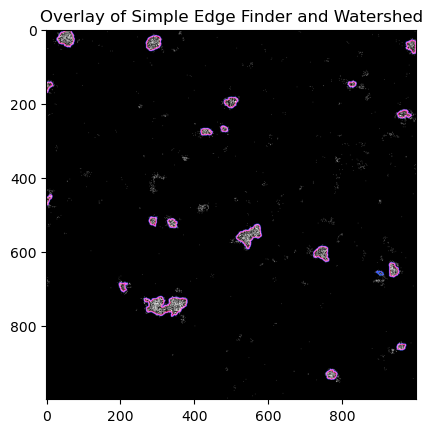

(1000, 1000, 3)


In [17]:
comb_contours = output_image + watershed_img

plt.imshow(comb_contours, cmap='gray')
plt.title("Overlay of Simple Edge Finder and Watershed")
plt.show()
print(comb_contours.shape)

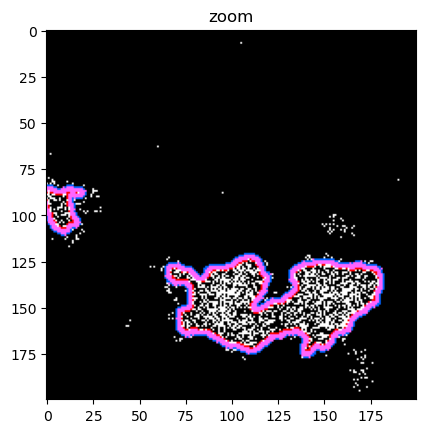

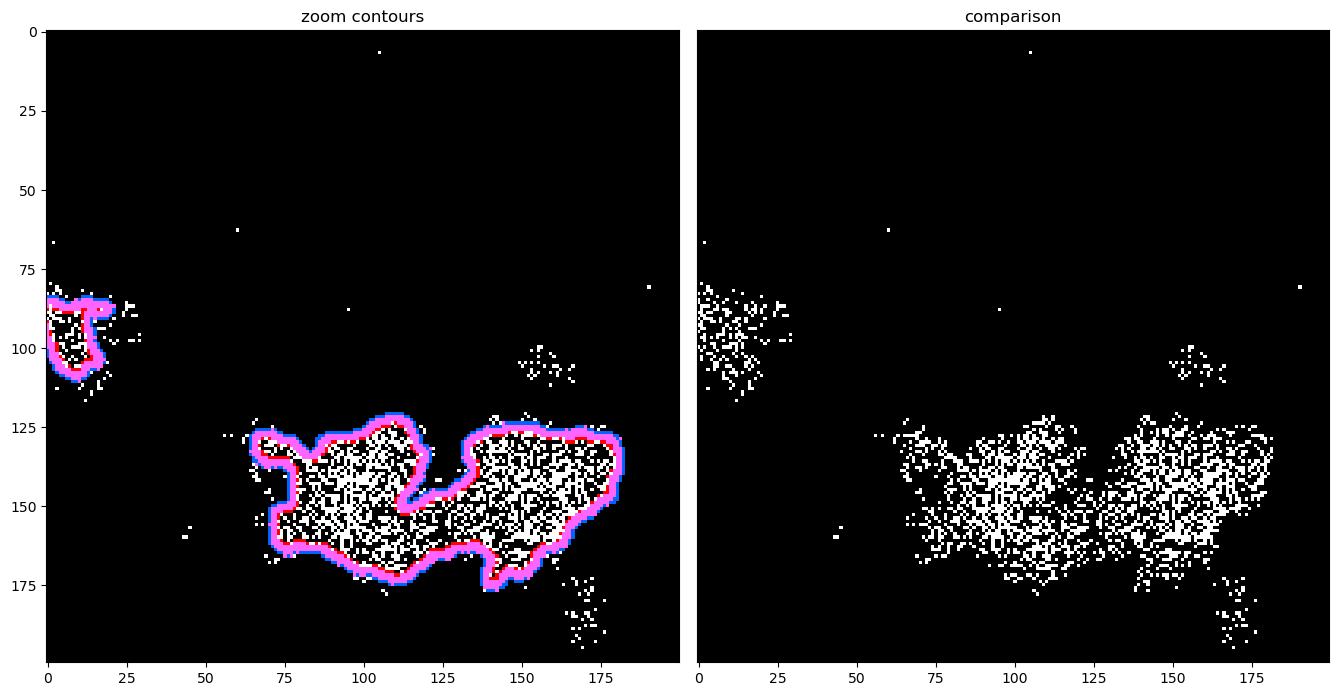

In [18]:
zoom_x = [200, 400]
zoom_y = [600, 800]

plt.imshow(comb_contours[zoom_y[0]:zoom_y[1], zoom_x[0]:zoom_x[1]], cmap='gray')
plt.title("zoom")
plt.show()

plt.figure(figsize=(20, 10))
plt.subplot(131),plt.imshow(comb_contours[zoom_y[0]:zoom_y[1], zoom_x[0]:zoom_x[1]], cmap='gray')
plt.title('zoom contours')
plt.subplot(132)
plt.title('comparison'), plt.yticks([])
plt.imshow(comp_slice[zoom_y[0]:zoom_y[1], zoom_x[0]:zoom_x[1]], cmap="gray")
plt.tight_layout()

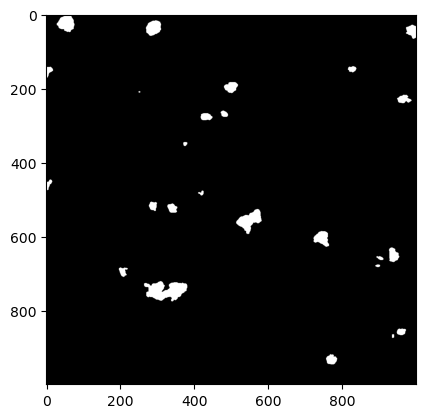

In [19]:
plt.imshow(opened_img, cmap='gray')

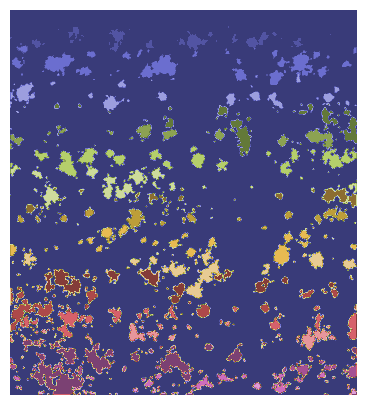

(886,)
pre sift:  884
883  cells found


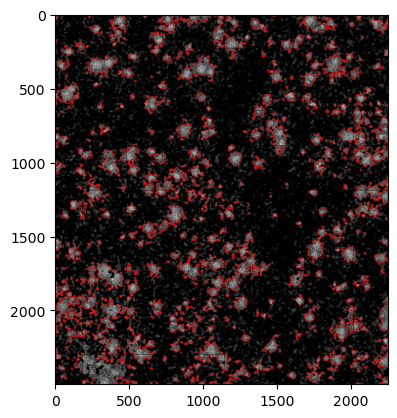

In [79]:
# Set the desired percentile for the distance transform
percentile_value = 0.1 # You can change this value as needed
dks = 5
min_area = 40
max_area = 30000

# Create a sure background area
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dks, dks))
sure_bg = cv2.dilate(opened_img, kernel, iterations=3)

# Distance transform
dist = cv2.distanceTransform(opened_img, cv2.DIST_L2, 5)

# Threshold to find sure foreground
ret, sure_fg = cv2.threshold(dist, percentile_value * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)

# Identify unknown area
unknown = cv2.subtract(sure_bg, sure_fg)

# Smooth distance transform
#smoothed_dt = gaussian_filter(dist, sigma=1)

# Use the specified percentile for marker creation
#threshold = np.percentile(smoothed_dt, percentile_value)
#local_maxima = (smoothed_dt > threshold).astype(np.uint8)

# Connected components for markers
ret, markers = cv2.connectedComponents(sure_fg)

# Prepare markers for watershed
markers += 1
markers[unknown == 255] = 0

# Apply watershed algorithm
markers = cv2.watershed(cv2.cvtColor(opened_img, cv2.COLOR_GRAY2BGR), np.int32(markers))

# Plot the watershed markers
plt.figure(figsize=(5, 5))
plt.imshow(markers, cmap="tab20b")
plt.axis('off')
plt.show()

# Extract contours for each label
labels = np.unique(markers)

print(labels.shape)
#print(labels)

coins = []
for label in labels[2:]:
    target = np.where(markers == label, 255, 0).astype(np.uint8)
    contours, _ = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if contours:  # Check if contours are found
        coins.append(contours[0])

# Filter contours by area and draw outlines
print("pre sift: ", len(coins))
filtered_coins = [cnt for cnt in coins if cv2.contourArea(cnt) > min_area]
filtered_coins = [cnt for cnt in coins if cv2.contourArea(cnt) < max_area]
watershed_img = cv2.drawContours(cv2.cvtColor(comp_slice, cv2.COLOR_GRAY2RGB), filtered_coins, -1, color=(255, 0, 0), thickness=2)
print(len(filtered_coins), " cells found")
plt.imshow(watershed_img)
